In [1]:
from __future__ import print_function
import tensorflow as tf 
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar100
import numpy as np
import os
import argparse 
import importlib
# print("Importing supporting files")
# import keras_template_resnet
# print("Successful")

# all function definitions 


def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=100):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=100):
    """ResNet Version 2 Model builder [b]
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tensorflow.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [2]:
version=2
num_classes=100
data_augmentation= True
epochs=50
batch_size=32

In [3]:
num=6
epochs = 90

In [4]:
# decides which resnet will get built here 
n = num 
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
print("****************************************************")
print("Model type is :", model_type)
print("****************************************************")

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth , num_classes =100)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth, num_classes =100)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)


# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar100_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

log_loss_array = []; log_accuracy_array =[]

class LossAndErrorPrintingCallback(tensorflow.keras.callbacks.Callback):
    # def on_train_batch_end(self, batch, logs=None):
    #     print("\nFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    # def on_test_batch_end(self, batch, logs=None):
    #     print("\nFor batch {}, loss is {:7.2f}.".format(batch, logs["loss"]))

    def on_epoch_end(self, epoch, logs=None):
        log_accuracy_array.append(logs["accuracy"])
        log_loss_array.append(logs["loss"])
        print("\nThe average loss for epoch {} is {:7.2f} and accuracy is {:7.2f}.".format(epoch, logs["loss"], logs["accuracy"]))

callbacks = [LossAndErrorPrintingCallback(), checkpoint, lr_reducer, lr_scheduler]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)
    model.save("ResNet56v2_model.h5")
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nLoss list:\n", log_loss_array , "\nAccuracy list:\n", log_accuracy_array)
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

****************************************************
Model type is : ResNet56v2
****************************************************
Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None,

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Using real-time data augmentation.
Epoch 1/90
Learning rate:  0.001
1563/1563 [==============================] - 62s 36ms/step - loss: 4.8480 - accuracy: 0.0955 - val_loss: 4.1290 - val_accuracy: 0.1538

The average loss for epoch 0 is    4.35 and accuracy is    0.14.

Epoch 00001: accuracy improved from -inf to 0.14106, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.001.h5
Epoch 2/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 3.5340 - accuracy: 0.2354 - val_loss: 3.5663 - val_accuracy: 0.2342

The average loss for epoch 1 is    3.40 and accuracy is    0.25.

Epoch 00002: accuracy improved from 0.14106 to 0.25496, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.002.h5
Epoch 3/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 3.0527 - accuracy: 


The average loss for epoch 21 is    1.66 and accuracy is    0.65.

Epoch 00022: accuracy improved from 0.64166 to 0.65052, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.022.h5
Epoch 23/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 1.6079 - accuracy: 0.6627 - val_loss: 1.9555 - val_accuracy: 0.5892

The average loss for epoch 22 is    1.64 and accuracy is    0.65.

Epoch 00023: accuracy improved from 0.65052 to 0.65456, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.023.h5
Epoch 24/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 1.5958 - accuracy: 0.6675 - val_loss: 2.3197 - val_accuracy: 0.5455

The average loss for epoch 23 is    1.63 and accuracy is    0.66.

Epoch 00024: accuracy improved from 0.65456 to 0.65764, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.024.h5
Epoch 25/90
Learning rate:  0.001
1563

1563/1563 [==============================] - 55s 35ms/step - loss: 1.3709 - accuracy: 0.7274 - val_loss: 2.1204 - val_accuracy: 0.5831

The average loss for epoch 44 is    1.40 and accuracy is    0.72.

Epoch 00045: accuracy improved from 0.71760 to 0.72048, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.045.h5
Epoch 46/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 1.3768 - accuracy: 0.7283 - val_loss: 2.0432 - val_accuracy: 0.6021

The average loss for epoch 45 is    1.40 and accuracy is    0.72.

Epoch 00046: accuracy improved from 0.72048 to 0.72274, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.046.h5
Epoch 47/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 1.3554 - accuracy: 0.7359 - val_loss: 2.0441 - val_accuracy: 0.5938

The average loss for epoch 46 is    1.39 and accuracy is    0.73.

Epoch 00047: accuracy improved from 0.72274

Epoch 69/90
Learning rate:  0.001
1563/1563 [==============================] - 54s 35ms/step - loss: 1.2652 - accuracy: 0.7600 - val_loss: 1.9512 - val_accuracy: 0.6301

The average loss for epoch 68 is    1.29 and accuracy is    0.75.

Epoch 00069: accuracy did not improve from 0.75582
Epoch 70/90
Learning rate:  0.001
1563/1563 [==============================] - 55s 35ms/step - loss: 1.2474 - accuracy: 0.7674 - val_loss: 2.2361 - val_accuracy: 0.5842

The average loss for epoch 69 is    1.27 and accuracy is    0.76.

Epoch 00070: accuracy improved from 0.75582 to 0.76040, saving model to /home/aastha/cifar100/saved_models/cifar100_ResNet56v2_model.070.h5
Epoch 71/90
Learning rate:  0.001
1563/1563 [==============================] - 56s 36ms/step - loss: 1.2362 - accuracy: 0.7674 - val_loss: 1.8856 - val_accuracy: 0.6368

The average loss for epoch 70 is    1.27 and accuracy is    0.76.

Epoch 00071: accuracy did not improve from 0.76040
Epoch 72/90
Learning rate:  0.001
1563/1563 [==

1563/1563 [==============================] - 23s 15ms/step - loss: 0.6759 - accuracy: 0.9204
Train loss: 0.6759258508682251
Train accuracy: 0.9203799962997437


In [6]:
Loss_list = np.array(
 [4.354527950286865, 3.400479316711426, 2.9953227043151855, 2.7454111576080322, 2.5585830211639404, 2.4237558841705322, 2.3060660362243652, 2.212228536605835, 2.1375606060028076, 2.0744447708129883, 2.0170352458953857, 1.9673815965652466, 1.9224936962127686, 1.8751758337020874, 1.8506622314453125, 1.8102837800979614, 1.786062240600586, 1.7487245798110962, 1.7311265468597412, 1.7088587284088135, 1.6903150081634521, 1.6598488092422485, 1.6449562311172485, 1.6305482387542725, 1.6131714582443237, 1.5984195470809937, 1.5902143716812134, 1.5679959058761597, 1.5533462762832642, 1.5478571653366089, 1.5358706712722778, 1.5205117464065552, 1.5078368186950684, 1.50054931640625, 1.4894739389419556, 1.4785270690917969, 1.4709906578063965, 1.4528892040252686, 1.4555472135543823, 1.4412387609481812, 1.4301366806030273, 1.4229873418807983, 1.426887035369873, 1.4155056476593018, 1.3996039628982544, 1.4011038541793823, 1.3890528678894043, 1.3863571882247925, 1.382576823234558, 1.3737256526947021, 1.3670121431350708, 1.3568445444107056, 1.3537932634353638, 1.3492780923843384, 1.345986247062683, 1.3441206216812134, 1.3393173217773438, 1.3291200399398804, 1.3261041641235352, 1.3263604640960693, 1.310044288635254, 1.307587742805481, 1.3054487705230713, 1.2990057468414307, 1.3001959323883057, 1.293593168258667, 1.2945903539657593, 1.288596749305725, 1.2881059646606445, 1.2728312015533447, 1.2722634077072144, 1.2698665857315063, 1.2599434852600098, 1.2638776302337646, 1.257699966430664, 1.2594250440597534, 1.249159336090088, 1.2427349090576172, 1.2511464357376099, 1.23470938205719, 1.2317734956741333, 1.0060724020004272, 0.9241074323654175, 0.8802949786186218, 0.847652018070221, 0.8210837244987488, 0.804374635219574, 0.7858693599700928, 0.766262948513031, 0.7506616115570068] )
Accuracy_list = np.array(
 [0.1410599946975708, 0.25496000051498413, 0.3251599967479706, 0.3805600106716156, 0.42215999960899353, 0.45254001021385193, 0.4810999929904938, 0.5048800110816956, 0.5222799777984619, 0.5413200259208679, 0.5537400245666504, 0.567359983921051, 0.580079972743988, 0.5887799859046936, 0.599399983882904, 0.6088600158691406, 0.6138799786567688, 0.6261000037193298, 0.6291400194168091, 0.6373599767684937, 0.6416599750518799, 0.6505200266838074, 0.6545600295066833, 0.6576399803161621, 0.6614999771118164, 0.6662399768829346, 0.6702600121498108, 0.6772400140762329, 0.678820013999939, 0.6809800267219543, 0.6870800256729126, 0.688539981842041, 0.6920999884605408, 0.6954600214958191, 0.6948999762535095, 0.6997600197792053, 0.7042800188064575, 0.7092400193214417, 0.7067999839782715, 0.7109400033950806, 0.7145799994468689, 0.7175999879837036, 0.7153000235557556, 0.7166399955749512, 0.7204800248146057, 0.7227399945259094, 0.7265200018882751, 0.725820004940033, 0.7313200235366821, 0.7304800152778625, 0.7311800122261047, 0.7343999743461609, 0.7358599901199341, 0.7380399703979492, 0.7370399832725525, 0.7416599988937378, 0.7399799823760986, 0.7414600253105164, 0.7423200011253357, 0.7425600290298462, 0.748520016670227, 0.7486600279808044, 0.7472599744796753, 0.7513999938964844, 0.7491199970245361, 0.7511399984359741, 0.7522600293159485, 0.7558199763298035, 0.7534199953079224, 0.7603999972343445, 0.7583199739456177, 0.7601000070571899, 0.762939989566803, 0.7605199813842773, 0.7623000144958496, 0.7602400183677673, 0.763260006904602, 0.7674999833106995, 0.763759970664978, 0.7690200209617615, 0.7703800201416016, 0.8408600091934204, 0.8621199727058411, 0.874019980430603, 0.8807799816131592, 0.8890399932861328, 0.8899999856948853, 0.8938599824905396, 0.8976600170135498, 0.8997200131416321])

In [11]:
len(Accuracy_list)

90

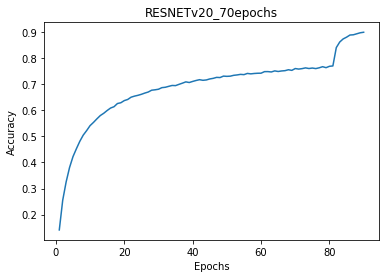

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(1, 90, num=90)
y1 = Accuracy_list

plt.figure()
plt.plot(x, y1)  

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("RESNETv20_70epochs")

plt.show()

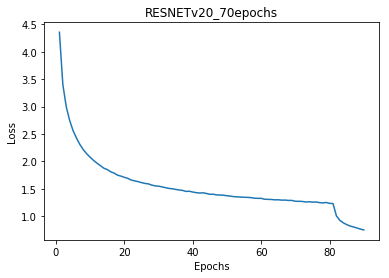

In [14]:
x = np.linspace(1, 90, num=90)
y1 = Loss_list

plt.figure()
plt.plot(x, y1)  

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RESNETv20_70epochs")

plt.show()

In [5]:
epochs = 15
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)
model.save("ResNet56v2_model.h5")
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nLoss list:\n", log_loss_array , "\nAccuracy list:\n", log_accuracy_array)
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

Epoch 1/15
Learning rate:  0.001
1375/1563 [=========================>....] - ETA: 6s - loss: 1.2189 - accuracy: 0.7596

KeyboardInterrupt: 

In [ ]:
epochs = 15
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)
model.save("ResNet56v2_model.h5")
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nLoss list:\n", log_loss_array , "\nAccuracy list:\n", log_accuracy_array)
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

In [ ]:
epochs = 15
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)
model.save("ResNet56v2_model.h5")
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

print("\nLoss list:\n", log_loss_array , "\nAccuracy list:\n", log_accuracy_array)
scores = model.evaluate(x_train, y_train, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])